## The purpose is to test the asymptotic behavior. We start with one independent variable X2, and one irrevalent variable X2

In [1]:
import numpy as np
from mip import Model, xsum, minimize, maximize, OptimizationStatus
from numpy.polynomial.polynomial import polyfit
import matplotlib.pyplot as plt
from numpy.linalg import inv
import time

EXP_TIMES = 500
TIME_LEVELS = 50
SAMPLE_AMOUNT = 5000

collection = np.zeros(EXP_TIMES)

start_time = time.time()
batch = 0

for exp in range(EXP_TIMES):
    # generate
    X1 = np.random.uniform(-1,1,SAMPLE_AMOUNT)
    X2 = np.random.uniform(-1,1,SAMPLE_AMOUNT)
    # X3 = np.random.uniform(-1,1,SAMPLE_AMOUNT)
    # X_2and3 = np.column_stack((X2, X3))
    
    EPSI = np.random.uniform(-1,1,SAMPLE_AMOUNT)
    
    Y = X1 + 2 + EPSI
    
    # phi(x) = x^2
    A = 4/45
    
    Q = 1/3
    # Q = 1/SAMPLE_AMOUNT * np.matmul(X_2and3.T,X_2and3)
    
    
    dual_density = np.zeros((TIME_LEVELS,SAMPLE_AMOUNT))
    
    
    m = Model()
    
    pi = [[m.add_var(lb=0,name="pi") for i in range(SAMPLE_AMOUNT)] for i in range(TIME_LEVELS)]
    
    for t in range(TIME_LEVELS):
        m += xsum(pi[t][i] for i in range(SAMPLE_AMOUNT)) == SAMPLE_AMOUNT/TIME_LEVELS
        m += xsum(pi[t][i]*X1[i] for i in range(SAMPLE_AMOUNT)) == xsum(X1[i] for i in range(SAMPLE_AMOUNT))/TIME_LEVELS
        
    for i in range(SAMPLE_AMOUNT):
        m += xsum(pi[t][i] for t in range(TIME_LEVELS)) == 1
        
    m.objective = maximize(xsum(xsum(t/TIME_LEVELS * Y[i] * pi[t-1][i] for i in range(SAMPLE_AMOUNT)) for t in range(1,TIME_LEVELS+1)))
    
    status = m.optimize(max_seconds=600)
    
    if not status == OptimizationStatus.OPTIMAL:
        print("SOMETHING WRONG!")
        break

    else:
        t=0
        i=0
        for v in m.vars: 
            dual_density[t][i] = v.x
            i+=1
            if i == SAMPLE_AMOUNT:
                i=0
                t+=1
    
    # calculate target statistics
    
    b=0
    for t in range(1,TIME_LEVELS+1):
        b +=  (t/TIME_LEVELS)**2 * (dual_density[t-1])
        
        
    # S = 1/np.sqrt(SAMPLE_AMOUNT) * np.matmul(X_2and3.T,b)
    S = 1/np.sqrt(SAMPLE_AMOUNT) * np.dot(X2,b)
    
    T_STAT = S**2/(A*Q)
    
    collection[exp] = T_STAT
    
    batch += 1
    
    if batch == 10:
        print(time.time()-start_time)
        print("experiment ",exp)
        batch = 0


753.1056981086731
experiment  9
1490.3609972000122
experiment  19
2243.009852409363
experiment  29
2972.4880216121674
experiment  39
3706.2734611034393
experiment  49
4452.654019117355
experiment  59
5201.232946395874
experiment  69
5939.544238805771
experiment  79
6664.464592218399
experiment  89
7400.690927743912
experiment  99
8144.921392440796
experiment  109
8926.537658452988
experiment  119
9690.317351579666
experiment  129
10432.767701864243
experiment  139
11186.32213973999
experiment  149
11955.759939432144
experiment  159
12700.650642156601
experiment  169
13467.044432401657
experiment  179
14222.873939752579
experiment  189
14976.2757833004
experiment  199
15725.234352111816
experiment  209
16458.205210208893
experiment  219
17192.491603136063
experiment  229
17936.981961488724
experiment  239
18685.684831142426
experiment  249
19429.120087862015
experiment  259
20173.63405919075
experiment  269
20903.366146087646
experiment  279
21654.68316078186
experiment  289
22403.90772

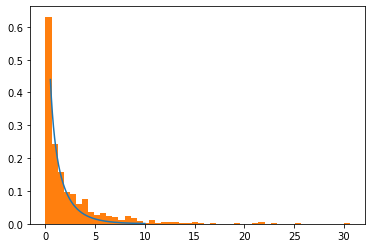

In [8]:
from scipy.stats import chi2

#x-axis ranges from 0 to 20 with .001 steps
x = np.arange(0.5, 10, 0.001)

#plot Chi-square distribution with 1 degrees of freedom
plt.plot(x, chi2.pdf(x, df=1))

plt.hist(collection, density=True, bins=50)

plt.show()

## The behavior is desirable. We consider instance wise estimation effect

In [16]:
import numpy as np
from mip import Model, xsum, minimize, maximize, OptimizationStatus
from numpy.polynomial.polynomial import polyfit
import matplotlib.pyplot as plt
from numpy.linalg import inv
import time

TIME_LEVELS = 50
SAMPLE_AMOUNT = 5000

collection = np.zeros(EXP_TIMES)

start_time = time.time()
batch = 0


X1 = np.random.uniform(-1,1,SAMPLE_AMOUNT)
    
EPSI = np.random.uniform(0,1,SAMPLE_AMOUNT)
    
Y = X1 + 2 + EPSI
    
dual_density = np.zeros((TIME_LEVELS,SAMPLE_AMOUNT))
    
m = Model()
    
pi = [[m.add_var(lb=0,name="pi") for i in range(SAMPLE_AMOUNT)] for i in range(TIME_LEVELS)]
    
for t in range(TIME_LEVELS):
    m += xsum(pi[t][i] for i in range(SAMPLE_AMOUNT)) == SAMPLE_AMOUNT/TIME_LEVELS
    m += xsum(pi[t][i]*X1[i] for i in range(SAMPLE_AMOUNT)) == xsum(X1[i] for i in range(SAMPLE_AMOUNT))/TIME_LEVELS
        
for i in range(SAMPLE_AMOUNT):
    m += xsum(pi[t][i] for t in range(TIME_LEVELS)) == 1
        
m.objective = maximize(xsum(xsum(t/TIME_LEVELS * Y[i] * pi[t-1][i] for i in range(SAMPLE_AMOUNT)) for t in range(1,TIME_LEVELS+1)))
    
status = m.optimize(max_seconds=600)
    
if not status == OptimizationStatus.OPTIMAL:
    print("SOMETHING WRONG!")

else:
    t=0
    i=0
    for v in m.vars: 
        dual_density[t][i] = v.x
        i+=1
        if i == SAMPLE_AMOUNT:
            i=0
            t+=1
            
print("done")

done


## consider, for every i, the actual quantile y_i-x_i-2 and estimation E_{pi_i}[t]

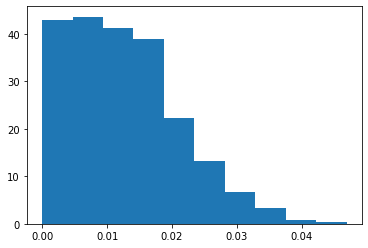

In [18]:
errors = np.zeros(SAMPLE_AMOUNT)

for i in range(SAMPLE_AMOUNT):
    estimation = sum([t/TIME_LEVELS * dual_density[t][i] for t in range(TIME_LEVELS)])
    errors[i] = np.abs(Y[i]-X1[i]-2-estimation)
    
plt.hist(errors, density=True, bins=10)

plt.show()

## So the estimation is actually pretty pretty good, now scale up the dimension to d